In [199]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import math

In [ ]:
def Scrape(start_page,end_page,file_name): #End page is not inclusive
    names,addresses,beds,baths,year_built,tenure,property_type,mrt,price,sqft = [],[],[],[],[],[],[],[],[],[]
    housing = ['HDB','HDB 2 Rooms','HDB 3 Rooms','HDB 4 Rooms','HDB 5 Rooms','HDB Executive','Condo','Apartment','Walk-up','Landed','Executive Condo','Terraced House','Corner Terrace','Semi-Detached','Bungalow','Good Class Bungalow','Cluster House']
    chrome_options = webdriver.ChromeOptions()
    for num in range(start_page,end_page):
        driver = webdriver.Chrome("chromedriver.exe")
        driver.implicitly_wait(5)
        driver.get('https://www.99.co/singapore/sale?page_num={}'.format(num))
        time.sleep(3)
        links =[]

        soup=BeautifulSoup(driver.page_source, 'lxml')
        for link in soup.find_all('a'):
            if type(link.get('href'))==str and 'Search' in link.get('href') and 'page_num'not in link.get('href'):

                links.append('https://www.99.co'+link.get('href'))


        for c,i in enumerate(links): 

            driver.get(i)
            time.sleep(1.5)
            soup=BeautifulSoup(driver.page_source, 'lxml')
            name = soup.find('h1', attrs={'class': '_3Wogd JMF8h lFqTi _1vzK2'})
            names.append(name.getText())


            address = soup.find_all('p', attrs={'class': 'dniCg _3j72o _2rhE-'})
            a = []
            for i in address:
                a.append(i.getText())
            addresses.append(re.findall('(\(D\d\d\)|\(D\d\))',''.join(a)))

            bed = soup.find_all('p', attrs={'class': '_2sIc2 _29qfj _2rhE-'})
            temp1 = ['NA','NA','NA']
            for i in bed:
                if 'Bed'in i.getText().split() or 'Beds' in i.getText().split():
                    temp1[0]=i.getText().split()[0]

                elif 'Bath' in i.getText().split() or 'Baths' in i.getText().split():
                    temp1[1]=i.getText().split()[0]

                elif 'sqft' in i.getText().split():
                    temp1[2]=i.getText().split()[0]
                elif 'Studio' in i.getText().split():
                    temp1[0]=i.getText()            
                else:
                    print('Please maunually get info for page{} and link with index {}'.format(num,c))

            beds.append(temp1[0])
            baths.append(temp1[1])
            sqft.append(temp1[2])


            info = soup.find_all('div', attrs={'class': '_3r4yN XCAFU'})
            temp = ['NA','NA','NA']

            for i in info:
                if 'year' in i.getText().lower():
                    temp[0]=i.getText()[:2]
                elif 'Freehold' in i.getText():
                    temp[0]=i.getText()
                elif re.findall('\d\d\d\d',i.getText())!=[]:
                    temp[1]=i.getText()
                elif i.getText() in housing:
                    temp[2]=i.getText()   
            tenure.append(temp[0])
            year_built.append(temp[1])
            property_type.append(temp[2])

            mrts = soup.find_all('p', attrs={'class': '_2sIc2 _2rhE- _1c-pJ'})
            temp2 = ['NA']
            for i in mrts:
                if re.findall('\(\d+ m\)',''.join(i.getText()))!=[]:
                        temp2[0]=re.findall('\(\d+ m\)',''.join(i.getText()))
            mrt.append(temp2[0])



            prices = soup.find('h2', attrs={'class': '_1zGm8 _3na6W _1vzK2'})
            price.append(prices.getText()[1:])

        if len(names)==len(addresses) and len(addresses)==len(beds) and len(beds)==len(baths) and len(baths)==len(year_built) and len(year_built)==len(tenure) and len(tenure)==len(property_type) and len(property_type)==len(mrt) and len(mrt)==len(price):
            print('All good for page number {}!'.format(num))
        else:
            print('shit, houston we have a problem!')
            break
        driver.close()
    data=pd.DataFrame(names,columns=['title'])
    data['address_code']=addresses
    data['beds']=beds
    data['baths']=baths
    data['year_built']=year_built
    data['tenure']=tenure
    data['property_type']=property_type
    data['mrt_distance']=mrt
    data['sqft']=sqft
    data['price']=price
    data.to_csv(file_name)
    print('Scraped Successfully! :)')

In [93]:
data_list = []
c=1
for i in range(17):
    data_list.append(pd.read_csv('scraped_pg{}_pg{}.csv'.format(c,c+9)))
    c+=10
data = pd.concat(data_list)
data.head()

Unnamed: 0                                         title address_code beds  \
0           0          HDB Flat for Sale in 110A Depot Road     ['(D4)']    3   
1           1   HDB Flat for Sale in 208B Clementi Avenue 6     ['(D5)']    2   
2           2    HDB Flat for Sale in 560 Hougang Street 51    ['(D19)']    4   
3           3    HDB Flat for Sale in 322C Anchorvale Drive    ['(D19)']    3   
4           4  HDB Flat for Sale in 225 Ang Mo Kio Avenue 1    ['(D20)']    2   

   baths year_built tenure property_type mrt_distance   sqft    price  
0    3.0        NaN     99           HDB          NaN    990  730,000  
1    2.0        NaN    NaN   HDB 3 Rooms  ['(906 m)']    731  610,000  
2    2.0       1999     99           HDB  ['(438 m)']  1,539  768,000  
3    2.0       2002     99           HDB  ['(369 m)']  1,184  558,888  
4    2.0       1978    NaN   HDB 3 Rooms          NaN    882  375,000

In [94]:
data1 = pd.read_csv('scraped_pg171_pg200.csv')
data2 = pd.read_csv('scraped_pg201_pg228.csv')
data_final = pd.concat([data,data1,data2])
data_final

Unnamed: 0                                          title address_code  \
0             0           HDB Flat for Sale in 110A Depot Road     ['(D4)']   
1             1    HDB Flat for Sale in 208B Clementi Avenue 6     ['(D5)']   
2             2     HDB Flat for Sale in 560 Hougang Street 51    ['(D19)']   
3             3     HDB Flat for Sale in 322C Anchorvale Drive    ['(D19)']   
4             4   HDB Flat for Sale in 225 Ang Mo Kio Avenue 1    ['(D20)']   
..          ...                                            ...          ...   
975         975             2 Bed Condo for Sale in Whitehaven     ['(D5)']   
976         976         3 Bed House for Sale in Sennett Estate    ['(D13)']   
977         977       3 Bed EC for Sale in Citylife @ Tampines    ['(D18)']   
978         978     5 Bed Condo for Sale in Hillion Residences    ['(D23)']   
979         979  5 Bed Condo for Sale in Affinity At Serangoon    ['(D19)']   

    beds  baths year_built    tenure    property_type  mrt_distance   sqft  \
0      3    3.0        NaN        99              HDB           NaN    990   
1      2    2.0        NaN       NaN      HDB 3 Rooms   ['(906 m)']    731   
2      4    2.0       1999        99              HDB   ['(438 m)']  1,539   
3      3    2.0       2002        99              HDB   ['(369 m)']  1,184   
4      2    2.0       1978       NaN      HDB 3 Rooms           NaN    882   
..   ...    ...        ...       ...              ...           ...    ...   
975    2    2.0       2017  Freehold        Apartment  ['(2460 m)']    538   
976    3    2.0        NaN  Freehold   Corner Terrace   ['(548 m)']  3,179   
977    3    3.0       2016        99  Executive Condo  ['(1128 m)']  1,216   
978    5    3.0       2018        99            Condo    ['(58 m)']  2,616   
979    5    5.0       2024        99            Condo           NaN  2,303   

         price  
0      730,000  
1      610,000  
2      768,000  
3      558,888  
4      375,000  
..         ...  
975    960,000  
976  4,500,000  
977  1,350,000  
978  3,029,000  
979  2,613,000  

[7980 rows x 11 columns]

In [95]:
data_final.drop('Unnamed: 0',axis=1,inplace=True)

In [96]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          7980 non-null   object 
 1   address_code   7980 non-null   object 
 2   beds           7974 non-null   object 
 3   baths          7414 non-null   float64
 4   year_built     7385 non-null   object 
 5   tenure         7475 non-null   object 
 6   property_type  7751 non-null   object 
 7   mrt_distance   6027 non-null   object 
 8   sqft           7980 non-null   object 
 9   price          7980 non-null   object 
dtypes: float64(1), object(9)
memory usage: 685.8+ KB


In [97]:
data_final.to_csv('compiled_data.csv')

In [186]:
data_final = pd.read_csv('compiled_data.csv',index_col=0)

<AxesSubplot:>

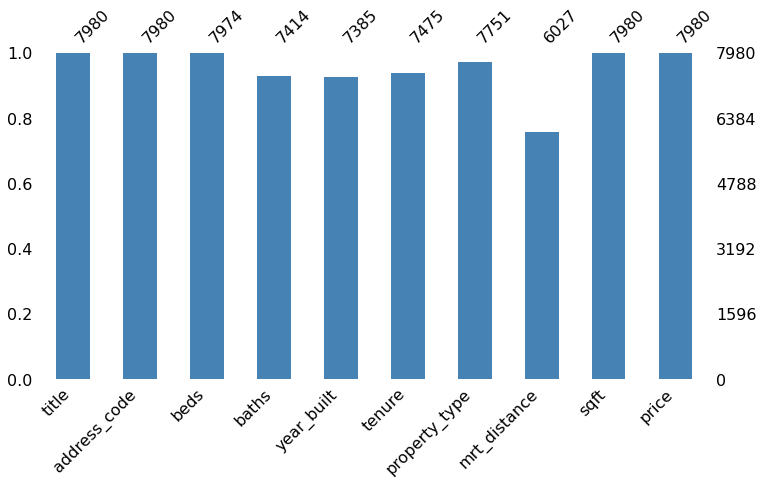

In [135]:
msno.bar(data_final, figsize=(12,6),color='steelblue')

In [187]:
data_final=data_final.drop_duplicates()

In [137]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6130 entries, 0 to 979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          6130 non-null   object 
 1   address_code   6130 non-null   object 
 2   beds           6124 non-null   object 
 3   baths          5660 non-null   float64
 4   year_built     5715 non-null   object 
 5   tenure         5732 non-null   object 
 6   property_type  5961 non-null   object 
 7   mrt_distance   4652 non-null   object 
 8   sqft           6130 non-null   object 
 9   price          6130 non-null   object 
dtypes: float64(1), object(9)
memory usage: 526.8+ KB


In [138]:
data_final['address_code'].value_counts()

['(D19)']    805
['(D10)']    495
['(D15)']    441
['(D18)']    393
['(D5)']     388
['(D9)']     388
['(D3)']     354
['(D14)']    280
['(D23)']    252
['(D4)']     236
['(D16)']    194
['(D11)']    186
['(D12)']    169
['(D27)']    168
['(D2)']     159
['(D28)']    155
['(D1)']     153
['(D21)']    144
['(D13)']    142
['(D20)']    135
['(D22)']    109
['(D7)']     108
['(D17)']     94
['(D8)']      89
['(D25)']     68
['(D26)']     23
['(D6)']       2
Name: address_code, dtype: int64

In [188]:
data_final['address_code']=data_final['address_code'].apply(lambda x: re.findall('D\d+',x)[0])

In [145]:
data_final['address_code'].value_counts()

D19    805
D10    495
D15    441
D18    393
D5     388
D9     388
D3     354
D14    280
D23    252
D4     236
D16    194
D11    186
D12    169
D27    168
D2     159
D28    155
D1     153
D21    144
D13    142
D20    135
D22    109
D7     108
D17     94
D8      89
D25     68
D26     23
D6       2
Name: address_code, dtype: int64

In [161]:
data_final['beds'].value_counts()

3     2119
2     1653
1      905
4      867
5      360
6       98
0       78
7       23
9        9
8        7
10       5
Name: beds, dtype: int64

In [189]:
data_final.dropna(subset=['beds'],inplace=True)

In [190]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6124 entries, 0 to 979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          6124 non-null   object 
 1   address_code   6124 non-null   object 
 2   beds           6124 non-null   object 
 3   baths          5654 non-null   float64
 4   year_built     5709 non-null   object 
 5   tenure         5726 non-null   object 
 6   property_type  5955 non-null   object 
 7   mrt_distance   4646 non-null   object 
 8   sqft           6124 non-null   object 
 9   price          6124 non-null   object 
dtypes: float64(1), object(9)
memory usage: 526.3+ KB


The defining difference between a studio and 1-bedroom apartment is that a 1-bedroom features a separate bedroom area that is distinct and closed off from the living room and kitchen area. The column beds represents the bedrooms on the website, since studio isn't a separate bedroom, I will change all labelled 'studio' to 0.

In [191]:

data_final['beds']=data_final['beds'].apply(lambda x:0 if x=='Studio' else int(x))

In [178]:
data_final['beds'].value_counts()

3     2119
2     1653
1      905
4      867
5      360
6       98
0       78
7       23
9        9
8        7
10       5
Name: beds, dtype: int64

In [202]:
data_final['baths']=data_final['baths'].apply(lambda x:0 if math.isnan(x) else int(x))

In [205]:
data_final['baths']

0      3
1      2
2      2
3      2
4      2
      ..
975    2
976    2
977    3
978    3
979    5
Name: baths, Length: 6124, dtype: int64